# N-layer Neural Network, and Layer as Class Objects
# Layers objects are customizable : size (number of neurons) and activation functions : sigmoid, relu, tanh
# supports multiclass outputs

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_circles
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tqdm import tqdm

In [29]:
class Layer:
    def __init__(self, n_neurons, activation='sigmoid'):
        
        self.n_neurons = n_neurons
        self.activation = activation
    
    def activation_function(self, Z):
        
        if self.activation == 'sigmoid':
            A = 1 / (1 + np.exp(-Z))
            return A
        elif self.activation == 'softmax':
            Z_exp = np.exp(Z)
            Z_sum = np.sum(Z_exp, axis=0, keepdims=True)
            A = Z_exp/Z_sum
            return A
        elif self.activation == "relu":
            return np.maximum(0, Z)
        elif self.activation == "tanh":
            return np.tanh(Z)
    
    def activation_derivative(self, Z):
        
        if self.activation == 'sigmoid':
            dA = Z * (1 - Z)
            return dA
        elif self.activation == 'relu':
            Z[Z<=0] = 0
            Z[Z>0] = 1
            return Z
        elif self.activation == 'tanh':
            return (1 - np.tanh(Z)**2)

In [54]:
class NN_Model:
    def __init__(self, X, hidden_layers:list, y) :
        
        self.X = X
        self.y = y 
        self.hidden_layers = hidden_layers
        
        self.L = len(hidden_layers)
        self.parameters = {}
        self.first_layer = Layer(X.shape[0])
        # condition of the last layer activation function : if multiclass then we use softmax
        if y.shape[0] > 1:
            self.last_layer = Layer(y.shape[0], 'softmax')
            self.loss_function = 'cross_entropy'
        else:
            self.last_layer = Layer(y.shape[0], 'sigmoid')
            self.loss_function = 'log_loss'

        # Weights and biases for the first layer (input size : X.shape[0])
        self.parameters["W1"] = np.random.randn(hidden_layers[0].n_neurons, self.first_layer.n_neurons)
        self.parameters["b1"] = np.random.randn(hidden_layers[0].n_neurons, 1)
        
        # Weights and biases for the hidden layers
        if self.L >= 2:
            for i in range(2,self.L+1):
                self.parameters[f"W{i}"] = np.random.randn(hidden_layers[i-1].n_neurons,hidden_layers[i-2].n_neurons)
                self.parameters[f"b{i}"] = np.random.randn(hidden_layers[i-1].n_neurons,1)
                
        # Weights and biases for the last layer (output size : y.shape[0])
        self.parameters[f"W{self.L+1}"] = np.random.randn(self.last_layer.n_neurons, hidden_layers[-1].n_neurons)
        self.parameters[f"b{self.L+1}"] = np.random.randn(self.last_layer.n_neurons, 1)
           
        self.parameters = dict(sorted(self.parameters.items())) # parameters contains all the weights and biases
        
        
    def forward_propagation(self, X, parameters):
        
        # first layer : calculation of Z1 and A1
        Z1 = parameters["W1"].dot(X) + parameters["b1"]
        A1 = self.first_layer.activation_function(Z1)
        activations = {"A1" : A1}
        
        for i in range(2, int(len(parameters)/2)+1) :
                        
            Z = parameters[f"W{i}"].dot(activations[f"A{i-1}"]) + parameters[f"b{i}"]
            
            if i == int(len(parameters)/2):
                # calculate the activation function for the last layer
                activations[f"A{i}"] = self.last_layer.activation_function(Z)
            else:
                # calculate the activation functions for the hidden layers
                activations[f"A{i}"] = self.hidden_layers[i-2].activation_function(Z)
        # COMMENTAIRE : réecrire en 3 blocs + simples en bouclant sur la longueur de hidden_layers            
        return activations
    
    
    def cross_entropy(self, y_true, activations):
        last_activation = list(activations.keys())[-1]
        final_activation = activations[last_activation]
        return -np.mean(y_true * np.log(final_activation))
    
    
    def log_loss(self, activations, y):
        eps = 1e-15
        last_activation = list(activations.keys())[-1]
        L = (-1/(y.shape[1])) * np.sum(y * np.log(activations[last_activation] + eps) + (1 - y) * np.log(1 - activations[last_activation] + eps))
        return L
    
    
    def predict(self, X, parameters):
        
        activations = self.forward_propagation(X, parameters)
        last_activation = list(activations.keys())[-1]
        if self.loss_function == 'log_loss':
            # in case of a binary output :
            return activations[last_activation] >= 0.5
        elif self.loss_function == 'cross_entropy':
            # in case of a multiclass output :
            final_prediction = activations[last_activation].argmax(axis=0)
            return final_prediction
    
    
    def back_propagation(self, X, y, activations, parameters):
        
        m = y.shape[1]
        
        dz = {}
        gradients = {}
        last_activation = list(activations.keys())[-1]
        
        # last layer
        dz[f"dz{int(last_activation[-1])}"] = activations[last_activation] - y
        gradients[f"dW{int(last_activation[-1])}"] = (1/m) * dz[f"dz{int(last_activation[-1])}"].dot(activations[f"A{int(last_activation[-1])-1}"].T)
        gradients[f"db{int(last_activation[-1])}"] = (1/m) * np.sum(dz[f"dz{int(last_activation[-1])}"], axis=1, keepdims=True)
        
        # hidden layers
        for i in range(len(activations)-1,1,-1):
            
            #dz[f"dz{i}"] = (parameters[f"W{i+1}"].T).dot(dz[f"dz{i+1}"]) * activations[f"A{i}"]*(1-activations[f"A{i}"])
            dz[f"dz{i}"] = (parameters[f"W{i+1}"].T).dot(dz[f"dz{i+1}"]) * self.hidden_layers[i-2].activation_derivative(activations[f"A{i}"])
            gradients[f"dW{i}"] = (1/m) * dz[f"dz{i}"].dot(activations[f"A{i-1}"].T)
            gradients[f"db{i}"] = (1/m) * np.sum(dz[f"dz{i}"], axis=1, keepdims=True)
        
        # first layer
        #dz["dz1"] = (parameters["W2"].T).dot(dz["dz2"]) * activations["A1"]*(1-activations["A1"])
        dz["dz1"] = (parameters["W2"].T).dot(dz["dz2"]) * self.first_layer.activation_derivative(activations["A1"])
        gradients["dW1"] = (1/m) * dz["dz1"].dot(X.T)
        gradients["db1"] = (1/m) * np.sum(dz["dz1"], axis=1, keepdims=True)

        return dict(sorted(gradients.items()))
    
    
    def fit(self, X_test=None, y_test=None, learning_rate=.01, n_epochs=1000, plot_scores=False, save_freq = 10):
        # training the model (with training data) using gradient descent algorithm
        
        loss_train, loss_test, accuracy_hist_train, accuracy_hist_test = [], [], [], []
        
        for i in tqdm(range(n_epochs)):
            
            activations = self.forward_propagation(self.X, self.parameters)

            # gradients calculation:
            gradients = self.back_propagation(self.X, self.y, activations, self.parameters)
            
            # gradients descent/update:
            for p,g in zip(self.parameters.keys(),gradients.keys()):
                self.parameters[p] = self.parameters[p] - learning_rate * gradients[g]
            
            if i % save_freq == 0:
                # TRAIN DATA : scores calculation   
                y_pred = self.predict(self.X, self.parameters)
                if self.loss_function == 'log_loss':
                    # accuracy for binary output
                    accuracy_hist_train.append(accuracy_score(self.y.flatten(), y_pred.flatten()))
                    # loss function for binary output:
                    loss_train.append(self.log_loss(activations, self.y))
                    
                elif self.loss_function == 'cross_entropy':
                    # accuracy for multiclass output
                    accuracy_hist_train.append((y_pred == self.y.argmax(axis=0)).mean())
                    # loss function for multiclass output
                    train_cost = self.cross_entropy(self.y, activations)
                    loss_train.append(train_cost)
                    
                # TEST DATA : scores calculation   
                if X_test is not None and y_test is not None:
                    y_pred_test = self.predict(X_test, self.parameters)
                    final_activation_test = self.forward_propagation(X_test, self.parameters)
                    if self.loss_function == 'log_loss':
                        # accuracy for binary output
                        accuracy_hist_test.append(accuracy_score(y_test.flatten(), y_pred_test.flatten()))
                        # loss function for binary output:
                        loss_test.append(self.log_loss(final_activation_test, y_pred_test))
                        
                    elif self.loss_function == 'cross_entropy':
                        # accuracy for multiclass output
                        accuracy_hist_test.append((y_pred_test == y_test.argmax(axis=0)).mean())
                        # loss function for multiclass output
                        test_cost = self.cross_entropy(y_test, final_activation_test)
                        loss_test.append(test_cost)
        
        scores = {"loss_train" : loss_train, "accuracy_train" : accuracy_hist_train,
                  "loss_test" : loss_test, "accuracy_test" : accuracy_hist_test}
        
        if plot_scores == True:
            plt.figure(figsize=(12,4))
            plt.subplot(1,2,1)
            plt.plot(range(len(loss_train)),loss_train, label="Train loss function")
            if X_test is not None and y_test is not None:
                plt.plot(range(len(loss_test)), loss_test, label="Test cost function")
            plt.title("Loss function")
            plt.legend()
            plt.subplot(1,2,2)
            plt.plot(range(len(accuracy_hist_train)),accuracy_hist_train, label="Train accuracy")
            if X_test is not None and y_test is not None:
                plt.plot(range(len(accuracy_hist_test)),accuracy_hist_test, label="Test accuracy")
            plt.title("Accuracy")
            plt.legend()
            plt.show()
        
        print(f"Train accuracy has reached {scores['accuracy_train'][-1]*100:.2f} %")
        if X_test is not None and y_test is not None:
            print(f"Test accuracy has reached {scores['accuracy_test'][-1]*100:.2f} %")
        
        return self.parameters, scores

In [55]:
X, y = make_circles(n_samples=1000, noise=.1, factor=.3, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# normalisation des données:
X_train_max = X_train.max()
X_train = X_train / X_train_max
X_test = X_test / X_train_max #ici on divise bien par la valeur max du train

X_train = X_train.T 
X_test = X_test.T 

y_train = y_train.reshape((y_train.shape[0],1)).T
y_test = y_test.reshape((y_test.shape[0],1)).T

#plt.figure(figsize=(4,3))
#plt.scatter(X[0,:],X[1,:],c=y, cmap='summer')
#plt.show()

In [56]:
model = NN_Model(X_train, [Layer(32, 'relu'), Layer(16, 'simoid')], y_train)

100%|██████████| 3000/3000 [00:02<00:00, 1190.05it/s]


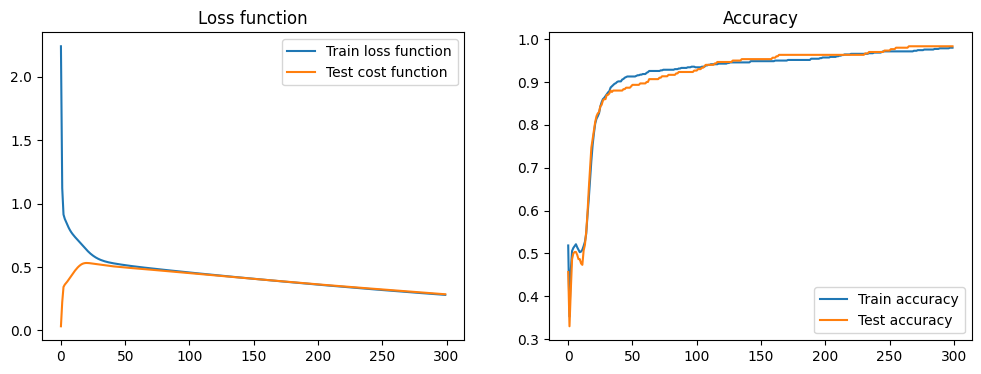

Train accuracy has reached 98.00 %
Test accuracy has reached 98.33 %


In [57]:
params_f, scores_f = model.fit(X_test=X_test, y_test=y_test, learning_rate=0.005, n_epochs=3000, plot_scores=True)

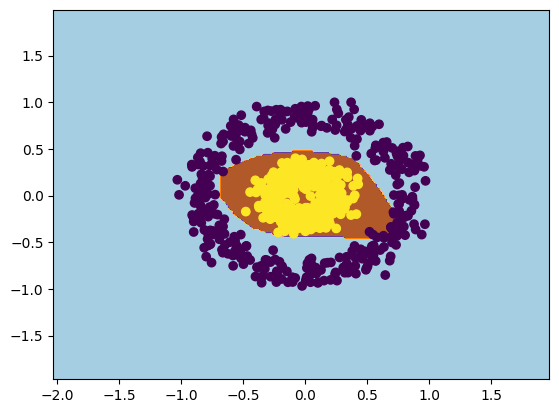

In [58]:
h = .02  # step size in the mesh
# create a mesh to plot in
x1_min, x1_max = X_train[0, :].min() - 1, X_train[0, :].max() + 1
x2_min, x2_max = X_train[1, :].min() - 1, X_train[1, :].max() + 1
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h),
                     np.arange(x2_min, x2_max, h))

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
fig, ax = plt.subplots()
Z = model.predict(np.c_[xx1.ravel(), xx2.ravel()].T, params_f)

# Put the result into a color plot
Z = Z.reshape(xx1.shape)
ax.contourf(xx1, xx2, Z, cmap=plt.cm.Paired)
#ax.axis('off')
plt.scatter(X_train[0,:],X_train[1,:],c=y_train)

plt.show()

# Multiclass example

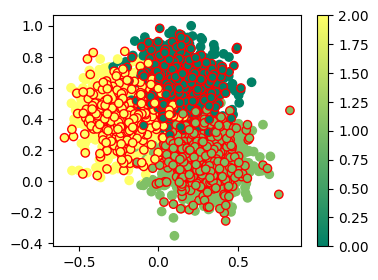

In [12]:
n_output_features = 3
X, y = make_blobs(n_samples=3000, n_features=2, centers=n_output_features, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# normalisation des données:
X_train_max = X_train.max()
X_train = X_train / X_train_max
X_test = X_test / X_train_max #ici on divise bien par la valeur max du train

X_train = X_train.T 
X_test = X_test.T 

# encodage des sorties (équivalent one hot encoder)
y_train_encoded = np.eye(n_output_features)[y_train].T
y_test_encoded = np.eye(n_output_features)[y_test].T


plt.figure(figsize=(4,3))
plt.scatter(X_train[0,:],X_train[1,:],c=y_train, cmap='summer')
plt.scatter(X_test[0,:],X_test[1,:],c=y_test, cmap='summer', edgecolors='red')
plt.colorbar()
plt.show()

In [13]:
model_mult = Model(X_train,[Layer(32, 'tanh')],y_train_encoded)

100%|██████████| 500/500 [00:00<00:00, 893.57it/s]


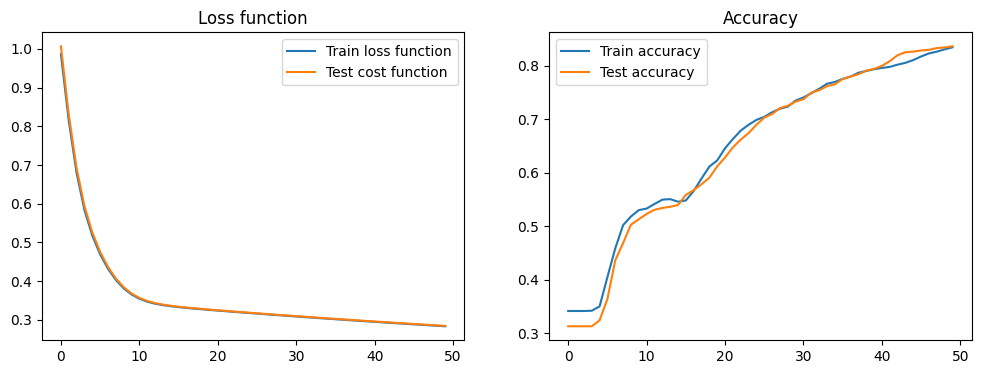

In [14]:
params_mult, scores_mult = model_mult.fit(X_test=X_test, y_test=y_test_encoded, learning_rate=0.01, n_epochs=500, plot_scores=True)

train accuracy :  0.8347619047619048
test accuracy :  0.8366666666666667


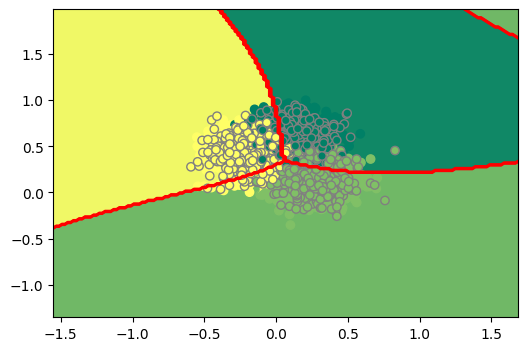

In [15]:
h = .02  # step size in the mesh
# create a mesh to plot in
x1_min, x1_max = X_train[0, :].min() - 1, X_train[0, :].max() + 1
x2_min, x2_max = X_train[1, :].min() - 1, X_train[1, :].max() + 1
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h),
                     np.arange(x2_min, x2_max, h))

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
plt.figure(figsize=(6,4))

last_activation = list(params_mult.keys())[-1]
Z = model_mult.forward_propagation(np.c_[xx1.ravel(), xx2.ravel()].T, params_mult)[f"A{int(last_activation[-1])}"]
# il faut réencoder Z pour passer de la taille (3 x 24024) à (1 x 24024) avec les valeurs de y
Z = Z.argmax(axis=0)

# Put the result into a color plot
Z = Z.reshape(xx1.shape)
plt.contourf(xx1, xx2, Z, cmap='summer')
plt.contour(xx1, xx2, Z, colors='red')
#ax.axis('off')
plt.scatter(X_train[0,:],X_train[1,:],c=y_train, cmap='summer')
plt.scatter(X_test[0,:],X_test[1,:],c=y_test, cmap='summer', edgecolors='gray')

print("train accuracy : ", scores_mult["accuracy_train"][-1])
print("test accuracy : ", scores_mult["accuracy_test"][-1])

plt.show()


# Cats/Dogs Images classification

In [16]:
import h5py

def load_data():
    train_dataset = h5py.File('datasets/trainset.hdf5', "r")
    X_train = np.array(train_dataset["X_train"][:]) # your train set features
    y_train = np.array(train_dataset["Y_train"][:]) # your train set labels

    test_dataset = h5py.File('datasets/testset.hdf5', "r")
    X_test = np.array(test_dataset["X_test"][:]) # your train set features
    y_test = np.array(test_dataset["Y_test"][:]) # your train set labels
    
    return X_train, y_train, X_test, y_test

In [17]:
X_train, y_train, X_test, y_test = load_data()

In [18]:
X_train_reshape = X_train.reshape(X_train.shape[0],-1) / X_train.max()
X_train_reshape = X_train_reshape.T

X_test_reshape = X_test.reshape(X_test.shape[0],-1) / X_train.max()
X_test_reshape = X_test_reshape.T

y_train = y_train.T
y_test = y_test.T

In [24]:
# MODEL
model_cd = Model(X_train_reshape,[Layer(128, 'relu'), Layer(64, 'relu'), Layer(64, 'relu')], y_train)

100%|██████████| 1000/1000 [00:26<00:00, 38.10it/s]


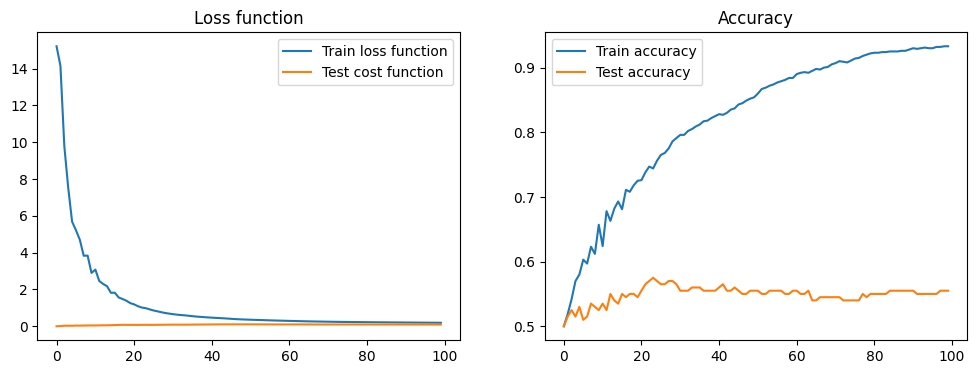

In [25]:
# Gradient Descent 
params_cd, scores_cd = model_cd.fit(X_test=X_test_reshape, y_test=y_test, learning_rate=0.01, n_epochs=1000, plot_scores=True)

## For such a complex task of classification (64 x 64 pixel images), the model overfits completely on training data